## Loading Data 

In [ ]:
#import required libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [ ]:
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import pandas as pd
df_train=pd.read_csv('/content/drive/MyDrive/temp.csv',index_col=0)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00 UTC,-73.955268,40.782767,-73.932382,40.794812,6
1,2014-06-30 11:26:37.0000001,6.0,2014-06-30 11:26:37 UTC,-73.995635,40.744387,-74.002325,40.730406,1
2,2012-04-08 13:42:13.0000001,5.3,2012-04-08 13:42:13 UTC,-73.992020,40.731651,-74.003277,40.731583,1
3,2009-08-18 11:18:00.000000117,6.9,2009-08-18 11:18:00 UTC,-73.993190,40.744670,-73.978242,40.752835,1
4,2013-04-30 08:00:00.000000137,7.5,2013-04-30 08:00:00 UTC,-73.992223,40.748710,-73.998547,40.758332,1


In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/test.csv',index_col=0)
df_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


## Data Preprocessing

In [ ]:
df_train=df_train.dropna()

In [ ]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,11.384571,-72.505704,39.947699,-72.509085,39.880209,1.687527
std,9.776925,10.558887,9.427363,10.570703,12.428476,1.311993
min,-45.000000,-84.483332,-74.014317,-77.724548,-3114.324368,0.000000
25%,6.000000,-73.991945,40.734983,-73.991306,40.734256,1.000000
50%,8.500000,-73.981758,40.752785,-73.980122,40.753279,1.000000
75%,12.500000,-73.966915,40.767399,-73.963844,40.768133,2.000000
max,230.000000,415.367817,2209.220368,471.286270,409.633332,6.000000


In [ ]:
#delete rows having fares greater than 200 and below 0
df_train = df_train.drop(df_train[df_train['fare_amount'] > 200].index)
df_train = df_train.drop(df_train[df_train['fare_amount'] < 0].index)

In [ ]:
train_y=df_train['fare_amount']
df_train=df_train.drop(columns=['fare_amount'])

In [ ]:
df_train.shape

(99994, 7)

In [ ]:
train_y.shape

(99994,)

In [ ]:
df=df_train.append(df_test)

## calculating Distance travelled 

In [ ]:
from math import sin, cos, sqrt, atan2, radians


In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [ ]:
df['distance'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

def Calculate_distance(lat1,lon1,lat2,lon2):
  # approximate radius of earth in km
  R = 6373.0
  dlon=lon2-lon1
  dlat=lat2-lat1
  a=sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  d=R*c
  return d 
distances_km=[]
for row in df.itertuples(index=False):
  distances_km.append(Calculate_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude))
df['distance']=distances_km

## Extracting datatime features

In [ ]:
def Extract_datetime_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['hour'] = df.pickup_datetime.dt.hour
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df["day"] = df.pickup_datetime.dt.weekday
    return df

In [ ]:
df=Extract_datetime_features(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109908 entries, 0 to 2015-01-18 14:06:23.0000006
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                99994 non-null   object             
 1   pickup_datetime    109908 non-null  datetime64[ns, UTC]
 2   pickup_longitude   109908 non-null  float64            
 3   pickup_latitude    109908 non-null  float64            
 4   dropoff_longitude  109908 non-null  float64            
 5   dropoff_latitude   109908 non-null  float64            
 6   passenger_count    109908 non-null  int64              
 7   distance           109908 non-null  float64            
 8   hour               109908 non-null  int64              
 9   month              109908 non-null  int64              
 10  year               109908 non-null  int64              
 11  day                109908 non-null  int64              
dtypes: datetime64[

In [ ]:
#dropping unnecessary columns
df=df.drop(columns=['key','pickup_datetime'])

In [ ]:
#defining categorical and conitous columns
cat_cols = ['hour', 'month', 'day','year']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']

In [ ]:
#making categorical columns and label to encode it 
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')

In [ ]:
#splitting data back to train and test
df_train=df[:99994]
df_test=df[99994:]

In [ ]:
#splitting data to train and eval
X_train, X_val, y_train, y_val = train_test_split(df_train, train_y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,month,year,day
38240,-74.002299,40.739662,-73.985565,40.661103,1,8.848535,3,2,1,3
3806,-73.956558,40.768122,-73.980217,40.765205,1,2.018701,22,6,0,4
27926,-73.999490,40.725307,-73.973002,40.758442,2,4.307546,12,5,3,2
6006,-73.984389,40.724894,-73.950033,40.775879,4,6.365229,0,0,4,5
65808,-73.995008,40.750061,-73.965820,40.764443,1,2.932822,18,8,1,1


In [ ]:
from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9.999400e+04,9.999400e+04,9.999400e+04,9.999400e+04,9.999400e+04,9.999400e+04
mean,6.688893e-14,-1.830808e-14,3.167741e-14,-1.222127e-14,-1.499828e-15,-2.907536e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00
min,-1.134541e+00,-1.208925e+01,-4.934299e-01,-2.537953e+02,-1.286225e+00,-5.468428e-02
25%,-1.407239e-01,8.347700e-02,-1.401866e-01,6.868960e-02,-5.240181e-01,-5.154932e-02
50%,-1.397590e-01,8.536556e-02,-1.391284e-01,7.022016e-02,-5.240181e-01,-4.920325e-02
75%,-1.383530e-01,8.691573e-02,-1.375882e-01,7.141525e-02,2.381887e-01,-4.467440e-02
max,4.621483e+01,2.301188e+02,5.145454e+01,2.975124e+01,3.287016e+00,4.197964e+01


## Model

In [ ]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [ ]:
#embeddings 
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (12, 6), (7, 4), (7, 4)]

In [ ]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

## Tabular Model

In [ ]:
from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [ ]:
torch.manual_seed(33)

In [ ]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 206.4)

In [ ]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(12, 6)
    (2): Embedding(7, 4)
    (3): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=

In [ ]:
#optimizer
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [ ]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 443.0302 train_rmse: 21.0488 | val_loss: 60.6186 val_rmse: 7.7786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 63.8009 train_rmse: 7.9877 | val_loss: 57.9003 val_rmse: 7.5978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 53.0755 train_rmse: 7.2855 | val_loss: 55.2346 val_rmse: 7.4466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 51.4694 train_rmse: 7.1740 | val_loss: 79.8721 val_rmse: 8.9155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 53.7993 train_rmse: 7.3349 | val_loss: 54.1216 val_rmse: 7.3678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 50.0976 train_rmse: 7.0778 | val_loss: 56.1611 val_rmse: 7.4276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 46.3338 train_rmse: 6.8070 | val_loss: 49.4433 val_rmse: 7.0430


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 43.7177 train_rmse: 6.6118 | val_loss: 49.2746 val_rmse: 7.0270


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 40.2729 train_rmse: 6.3462 | val_loss: 34.9268 val_rmse: 5.8859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 30.1447 train_rmse: 5.4904 | val_loss: 36.8858 val_rmse: 6.0792



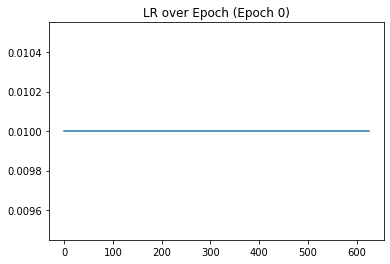

In [ ]:
#plotting learning rate
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')

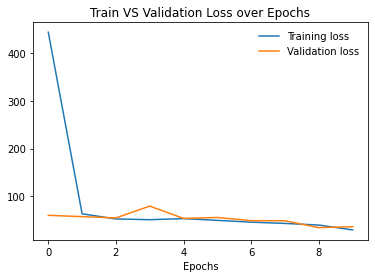

In [ ]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)